Pixeltests School Data Science

*Unit 2, Sprint 2, Module 4*

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/pixeltests/datasets/main/' #You might not need this, use the data from Kaggle directly!
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions



The tasks for this project are as follows:
- **Task 0:** Enter the [Kaggle](https://www.kaggle.com/t/6169ee7701164d24943c98eda2de9b5e) competition using exactly this link!
- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [3]:
import pandas as pd

def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [19]:
df = pd.read_csv('/content/drive/MyDrive/Pixeltest/predict-faulty-tanzania-water-pumps/train_features.csv')
lables_df = pd.read_csv('/content/drive/MyDrive/Pixeltest/predict-faulty-tanzania-water-pumps/train_labels.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Pixeltest/predict-faulty-tanzania-water-pumps/test_features.csv')
print('Shape of dataset',{df.shape})
df.head()

Shape of dataset {(47520, 40)}


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,1027,50.0,2013-02-13,Kiuma,690,KIUMA,36.957086,-11.311964,Kwa Mkwanda Mohamed,0,...,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
1,16782,0.0,2011-07-26,Hesawa,0,DWE,33.058573,-2.595762,Kwa Lujina,0,...,monthly,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
2,13169,0.0,2011-03-14,Ded,0,DWE,35.238216,-5.168248,Kilimba A,0,...,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
3,18341,0.0,2013-04-03,Adra,1300,Adra/Community,36.941756,-3.336709,John,0,...,unknown,unknown,unknown,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
4,66703,10.0,2013-09-03,Giz,791,KILI WATER,37.469637,-3.393065,Kwa Iddi Mlaki,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [5]:
X = df
y = lables_df

**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Optional: check the shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (38016, 40)
X_val shape: (9504, 40)
y_train shape: (38016, 1)
y_val shape: (9504, 1)


# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [7]:
print(y_train['status_group'].value_counts(normalize=True))

#  majority class in y_train
majority_class = y_train.value_counts().idxmax()
majority_count = y_train.value_counts().max()

# baseline accuracy
baseline_acc = majority_count / len(y_train)

print('Baseline Accuracy Score:', baseline_acc)

status_group
functional                 0.542298
non functional             0.384549
functional needs repair    0.073153
Name: proportion, dtype: float64
Baseline Accuracy Score: 0.5422979797979798


# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [8]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

model = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(max_depth=13,n_estimators=200,n_jobs=-1,random_state=42)
)

model = model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [9]:
training_acc =  model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8445391414141414
Validation Accuracy Score: 0.7917718855218855


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

<Axes: >

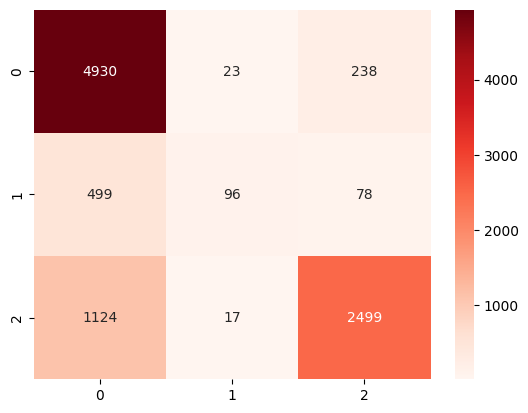

In [10]:
# Plot 3x3 confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')

Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [11]:
# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.75      0.95      0.84      5191
functional needs repair       0.71      0.14      0.24       673
         non functional       0.89      0.69      0.77      3640

               accuracy                           0.79      9504
              macro avg       0.78      0.59      0.62      9504
           weighted avg       0.80      0.79      0.77      9504



# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?


**Task 9:** Using your model's `predict_proba` method, identify the observations in your **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [12]:
print(model.named_steps['randomforestclassifier'].classes_)

proba = model.predict_proba(X_test)
proba

non_func_probs = proba[:, 2]

X_test_nf = X_test[non_func_probs > 0.95]
print(X_test_nf.shape)

print(f"Model is over 95% confident that {len(X_test_nf)} pumps are non-functional.")
X_test_nf.head()


['functional' 'functional needs repair' 'non functional']
(942, 40)
Model is over 95% confident that 942 pumps are non-functional.


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
26,16291,0.0,2013-03-13,0,-47,0,39.361223,-6.861210,Kwa Abbas Mwinyichum,0,...,never pay,salty,salty,dry,dry,machine dbh,borehole,groundwater,other,other
52,61610,0.0,2011-07-22,Government Of Tanzania,0,DWE,30.893949,-1.478067,Kwanovati,0,...,never pay,soft,good,dry,dry,river,river/lake,surface,communal standpipe,communal standpipe
62,63098,0.0,2011-03-14,Healt,1384,Healt,34.714240,-9.805399,none,0,...,on failure,soft,good,dry,dry,river,river/lake,surface,communal standpipe,communal standpipe
80,24756,0.0,2011-03-07,District Council,-14,DWE,38.933308,-5.567187,Baalii Sudi,0,...,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other
108,69604,0.0,2013-02-07,Lga,320,LGA,39.190458,-11.014937,Shuleni,0,...,unknown,soft,good,dry,dry,spring,spring,groundwater,communal standpipe multiple,communal standpipe


**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [13]:
X_test_nf = X_test[non_func_probs > 0.99444]
print(X_test_nf.shape)

(100, 40)


# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).

In [14]:
import plotly.express as px

# Scatter plot on Mapbox
fig = px.scatter_mapbox(
    X_test_nf,
    lat="latitude",
    lon="longitude",
    zoom=4,
    height=600,
    title="Top 100 Most At-Risk Non-Functional Pumps",
    color_discrete_sequence=["red"]
)

# Use open-street-map style (free & public)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

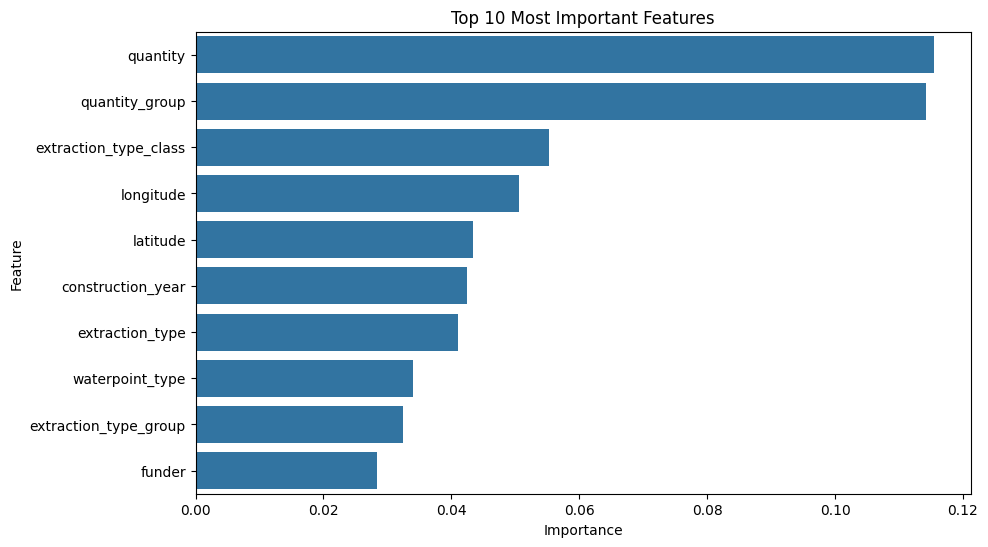

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


# Get feature importances
importances = model.named_steps['randomforestclassifier'].feature_importances_

# Get feature names after encoding
# Use 'ordinalencoder' instead of 'ce.ordinalencoder'
feature_names = model.named_steps['ordinalencoder'].get_feature_names_out()

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Most Important Features')
plt.show()

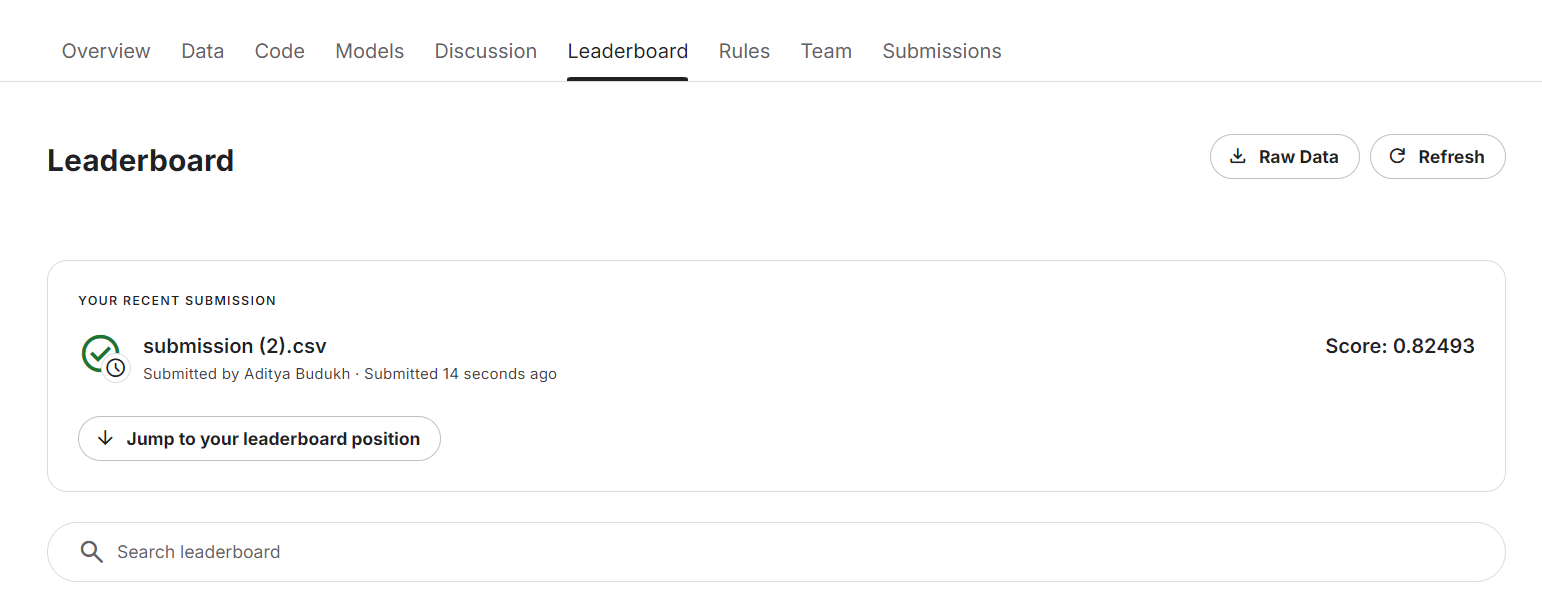